In [1]:
from cbt_preprocessing import CBTProcessor
from utils import sanity_data_maker
import numpy as np

EMBED_DIM = 50
TERM_LOWER_BOUND = 0

# give path to text corpus and embeddings
data_loader = CBTProcessor('data/cbt_train.txt', 'data/glove.6B.50d.txt', EMBED_DIM, TERM_LOWER_BOUND)

Words extracted. Total number: 51859
Number of pre-trained: 35933


In [2]:
sanity_data_maker('data/cbtest_NE_train.txt', 'data/cbtest_NE_sanity_train.txt', 20000, 10)
sanity_data_maker('data/cbtest_NE_valid_2000ex.txt', 'data/cbtest_NE_sanity_val.txt', 500, 10)

(186.166, 23.834)

In [3]:
# prepare for batch generation on train and val splits
DOC_LEN = 200
QUERY_LEN = 50
data_loader.fit_on_texts('data/cbtest_NE_train.txt', 'train', DOC_LEN, QUERY_LEN, 10)
data_loader.fit_on_texts('data/cbtest_NE_valid_2000ex.txt', 'val', DOC_LEN, QUERY_LEN, 10)

In [4]:
# check batch sampling
ex_batch_train = data_loader.sample_batch('train', 32)
data_loader.show_example(ex_batch_train)

DOC:
trust peter for that ! but everybody else helped too . you see , they had all been afraid of farmer brown 's boy for so long that they were tickled almost to pieces at the very thought of having some one in the green forest who could make farmer brown 's boy feel fear as they had felt it . and so it was that buster bear became a hero right away to most of them . a few doubted little joe 's story . one of them was blacky the crow . another was reddy fox . blacky doubted because he knew farmer brown 's boy so well that he could n't imagine him afraid . reddy doubted because he did n't want to believe .
----------
QUERY:
you see , he was jealous of buster XXXXX , and at the same time he was afraid of him .
----------
ANSWER:
bear


In [5]:
# each batch contains:
# docs and queries
ex_D_train, ex_Q_train = ex_batch_train[0], ex_batch_train[1]
print('Doc shape:', ex_D_train.shape)
print('Query shape:', ex_Q_train.shape)
# 10 possible candidates
ex_C_train = ex_batch_train[2]
print('-'*10)
print('Cands shape:', ex_C_train.shape)
# real answers
ex_A_train = ex_batch_train[3]
print('-'*10)
print('Answer shape:', ex_A_train.shape)
# Doc2Query Masks
print('-'*10)
print('Lengths shape:', ex_batch_train[4].shape, ex_batch_train[5].shape)

Doc shape: (32, 200)
Query shape: (32, 50)
----------
Cands shape: (32, 10)
----------
Answer shape: (32,)
----------
Lengths shape: (32,) (32,)


# End-To-End Memory Network

In [6]:
import tensorflow as tf
from utils import masked_mean, masked_softmax, val_accuracy

In [7]:
tf.reset_default_graph()

n_hops = 5
drop_keep_p = 0.8

X = tf.placeholder(tf.int32, [None, DOC_LEN], name='Doc')
q = tf.placeholder(tf.int32, [None, QUERY_LEN], name='Query')
a = tf.placeholder(tf.int32, [None,], name='Answer')
X_len = tf.placeholder(tf.int32, [None,], name='Doc_lengths')
q_len = tf.placeholder(tf.int32, [None,], name='Query_lengths')

A_emb = tf.Variable(data_loader.embeddings, name='Input_embeddings')
C_emb = A_emb
#C_emb = tf.Variable(data_loader.embeddings, name='Output_embeddings')
H = tf.Variable(tf.eye(EMBED_DIM,dtype=tf.float64), name='Hop_Shift')
U = tf.transpose(A_emb, perm=(1,0))
A_temp = tf.Variable(tf.zeros([DOC_LEN,EMBED_DIM], tf.float64), name='Input_temporal_encoding')
#C_temp = A_temp
C_temp = tf.Variable(tf.zeros([DOC_LEN,EMBED_DIM], tf.float64), name='Output_temporal_encoding')
q_temp = tf.Variable(tf.zeros([QUERY_LEN,EMBED_DIM], tf.float64), name='Query_temporal_encoding')

masked_D = tf.reverse_v2(tf.sequence_mask(X_len, maxlen=DOC_LEN, dtype=tf.float64), [1])
masked_q = tf.sequence_mask(q_len, maxlen=QUERY_LEN, dtype=tf.float64)

m = tf.nn.dropout(tf.nn.embedding_lookup(A_emb, X, name='Memory_vectors')+A_temp, drop_keep_p)

full_u = tf.nn.dropout(tf.nn.embedding_lookup(A_emb, q)+q_temp, drop_keep_p)
u = masked_mean(full_u, tf.expand_dims(masked_q,2), axis=1, keepdims=False)
#u = tf.layers.dense(avg_u, EMBED_DIM, name='Internal_state')
c = tf.nn.dropout(tf.nn.embedding_lookup(C_emb, X, name='Output_vectors')+C_temp, drop_keep_p)

def one_hop(X, m, u, c):
    unnormed = tf.reshape(m @ tf.reshape(u, [-1, EMBED_DIM, 1]), [-1, DOC_LEN])
    p = masked_softmax(unnormed / (EMBED_DIM**0.5), masked_D, axis=1)
    return tf.reduce_sum(tf.expand_dims(p, 2) * c, axis=1)

for i in range(n_hops):
    o = one_hop(X, m, u, c)
    u = tf.nn.relu(u @ H + o)

a_hat_logits = u @ U
a_hat = tf.nn.softmax(a_hat_logits / (EMBED_DIM**0.5), name='Predictions')

train_loss = tf.losses.sparse_softmax_cross_entropy(a, a_hat_logits)
hard_acc_score = tf.contrib.metrics.accuracy(tf.argmax(a_hat, axis=1, output_type=tf.int32), a)

optim = tf.train.AdamOptimizer(1e-2*25/EMBED_DIM)
train_op = optim.minimize(train_loss)

In [8]:
tf.trainable_variables()

[<tf.Variable 'Input_embeddings:0' shape=(51859, 50) dtype=float64_ref>,
 <tf.Variable 'Hop_Shift:0' shape=(50, 50) dtype=float64_ref>,
 <tf.Variable 'Input_temporal_encoding:0' shape=(200, 50) dtype=float64_ref>,
 <tf.Variable 'Output_temporal_encoding:0' shape=(200, 50) dtype=float64_ref>,
 <tf.Variable 'Query_temporal_encoding:0' shape=(50, 50) dtype=float64_ref>]

In [9]:
from tqdm import tqdm

def train_model(sess, data_loader, validate=True,
                debug=True, batch_size=50, n_epochs=10, tol=1e-4, sk=10):
    tr_losses, tr_accs, te_accs = [], [], []
    steps_per_epoch = data_loader.train_data_len // (batch_size)
    total_epochs = 0
    
    for epoch in tqdm(range(n_epochs)):
        total_epochs += 1
        if debug:
            print('-'*10)
            print('EPOCH:', epoch)
        ctr_acc = 0
        
        for step in range(steps_per_epoch):
            tr_sample = data_loader.sample_batch('train', batch_size)
            tr_dict = {X:tr_sample[0],q:tr_sample[1],
                       a:tr_sample[3],X_len:tr_sample[4],q_len:tr_sample[5]}
            _, closs, cacc = sess.run([train_op, train_loss, hard_acc_score],
                                     feed_dict=tr_dict)
            tr_losses += [closs]
            ctr_acc += cacc
        
        ctr_acc /= steps_per_epoch
        tr_accs += [ctr_acc]
        
        
        if validate:
            params = [X, q, a, X_len, q_len]
            cte_acc = val_accuracy(sess, data_loader, hard_acc_score, params)
            te_accs += [cte_acc]
            if len(te_accs) > sk:
                cmed = np.mean(te_accs[-sk:])
                if (cte_acc - cmed) / cmed < tol:
                    if debug:
                        print('Finished')
                    break
        if debug:
            print('Train cross entropy:', tr_losses[-1])
            print('Train accuracy:', ctr_acc)
            if validate:
                print('Val accuracy:', te_accs[-1])
    return tr_losses, tr_accs, te_accs, total_epochs

In [10]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

tr_losses, tr_accs, val_accs, exec_epochs = train_model(sess, data_loader, validate=True, 
                                                        debug=True, batch_size=50, n_epochs=40)

  0%|          | 0/40 [00:00<?, ?it/s]

----------
EPOCH: 0


  2%|▎         | 1/40 [21:53<14:13:52, 1313.66s/it]

Train cross entropy: 4.438581466674805
Train accuracy: 0.16421343100521962
Val accuracy: 0.18549999929964542
----------
EPOCH: 1


  5%|▌         | 2/40 [42:24<13:25:42, 1272.17s/it]

Train cross entropy: 3.5781383514404297
Train accuracy: 0.2916375347725848
Val accuracy: 0.1979999989271164
----------
EPOCH: 2


  8%|▊         | 3/40 [1:01:16<12:35:42, 1225.48s/it]

Train cross entropy: 3.2021429538726807
Train accuracy: 0.34913523531867585
Val accuracy: 0.19599999859929085
----------
EPOCH: 3


 10%|█         | 4/40 [1:21:01<12:09:11, 1215.31s/it]

Train cross entropy: 3.2121779918670654
Train accuracy: 0.38759889610612075
Val accuracy: 0.21050000041723252
----------
EPOCH: 4


 12%|█▎        | 5/40 [1:40:27<11:43:09, 1205.42s/it]

Train cross entropy: 2.654339075088501
Train accuracy: 0.421223550445461
Val accuracy: 0.21500000059604646
----------
EPOCH: 5


 15%|█▌        | 6/40 [1:59:59<11:19:59, 1199.99s/it]

Train cross entropy: 2.140019178390503
Train accuracy: 0.44813247367725967
Val accuracy: 0.19600000008940696
----------
EPOCH: 6


 18%|█▊        | 7/40 [2:20:36<11:02:51, 1205.20s/it]

Train cross entropy: 2.4521710872650146
Train accuracy: 0.4766881322109491
Val accuracy: 0.20799999982118605
----------
EPOCH: 7


 20%|██        | 8/40 [2:40:23<10:41:35, 1202.99s/it]

Train cross entropy: 2.099588632583618
Train accuracy: 0.4982796685209818
Val accuracy: 0.2214999996125698
----------
EPOCH: 8


 22%|██▎       | 9/40 [2:57:39<10:11:57, 1184.44s/it]

Train cross entropy: 1.529384970664978
Train accuracy: 0.5192456303135232
Val accuracy: 0.20150000117719175
----------
EPOCH: 9


 25%|██▌       | 10/40 [3:14:51<9:44:33, 1169.13s/it]

Train cross entropy: 1.670914888381958
Train accuracy: 0.5424563024388395
Val accuracy: 0.22200000137090684
----------
EPOCH: 10


 28%|██▊       | 11/40 [3:32:03<9:19:03, 1156.67s/it]

Train cross entropy: 1.6573506593704224
Train accuracy: 0.5563017491528828
Val accuracy: 0.2195000022649765
----------
EPOCH: 11


 30%|███       | 12/40 [3:49:07<8:54:37, 1145.63s/it]

Train cross entropy: 1.256401777267456
Train accuracy: 0.572235512330429
Val accuracy: 0.2175000011920929
----------
EPOCH: 12
Finished


In [11]:
steps_per_epoch = data_loader.train_data_len // 50
plt_epochs = [k+l/steps_per_epoch for k in range(exec_epochs) for l in range(steps_per_epoch)]

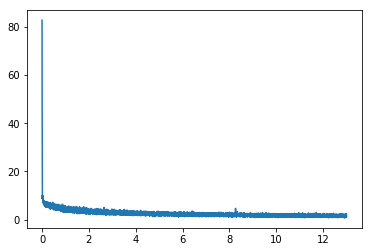

In [12]:
from matplotlib import pyplot as plt
plt.plot(plt_epochs, tr_losses)
plt.show()

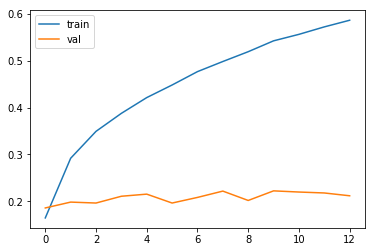

0.22200000137090684


In [13]:
plt.plot(tr_accs, label='train')
plt.plot(val_accs, label='val')
plt.legend()
plt.show()
print(np.max(val_accs))

In [19]:
# example
b_size=10
ex_sample = data_loader.sample_batch('val', b_size)
ex_dict = {X:ex_sample[0],q:ex_sample[1],X_len:ex_sample[4],q_len:ex_sample[5]}
    
ex_mask, ex_hat = sess.run([masked_D, a_hat], feed_dict=ex_dict)

data_loader.show_example(ex_sample)

DOC:
he did n't know why he had done it , excepting that he had become dissatisfied and discontented and unhappy in his old home . and then , almost without thinking what he was doing , he had told jimmy skunk that he could have the house he had worked so hard to build the summer before and of which he had been so proud . then johnny chuck had swaggered away down the lone little path without once looking back at the home he was leaving . where was he going ? well , to tell the truth , johnny did n't know . he was going to see the world , and perhaps when he had seen the world , he would build him a new house . so as long as he was in sight of jimmy skunk , he swaggered along quite as if he was used to traveling about , without any snug house to go to at night .
----------
QUERY:
but right down in his heart johnny XXXXX did n't feel half so bold as he pretended .
----------
ANSWER:
chuck


In [20]:
ex_mask.shape

(10, 200)

In [21]:
new_emb = sess.run(A_emb)

In [22]:
for i in range(b_size):
    print('-'*10)
    print('true:', data_loader.id_to_word[ex_sample[3][i]])
    cands = ex_sample[2][i]
    c_hat = ex_hat[i,:]
    scores = c_hat[cands]
    max_ind = np.argmax(scores)
    print('pred:', data_loader.id_to_word[cands[max_ind]], '%6.5f'%scores[max_ind])
    #for k in range(10):
    #    print(data_loader.id_to_word[cands[k]], '%6.5f'%scores[k])

----------
true: peter
pred: night 0.00017
----------
true: chuck
pred: right 0.00029
----------
true: <NA>
pred: hours 0.00016
----------
true: <NA>
pred: first 0.00025
----------
true: reade
pred: left 0.00030
----------
true: king
pred: king 0.00018
----------
true: <NA>
pred: death 0.00011
----------
true: dan
pred: mind 0.00005
----------
true: jack
pred: right 0.00057
----------
true: cecily
pred: years 0.00018


In [54]:
k = np.random.randint(b_size)
inds = ex_hat[k].argsort()[-5:][::-1]
print('Answer:', data_loader.id_to_word[ex_sample[3][k]])
print('Predictions:')
for ind in inds:
    print('Word:', data_loader.id_to_word[ind], '\t Score:', ex_hat[k][ind])

Answer: johnny
Predictions:
Word: fire 	 Score: 0.00014342232268313361
Word: first 	 Score: 0.00012827592106156931
Word: prigio 	 Score: 0.00012822506101239318
Word: night 	 Score: 0.00012581254270265673
Word: firedrake 	 Score: 0.00012541240576969672
